In [1]:
%matplotlib inline

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_nn_long.ipynb)

[![View Source on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_nn_long.ipynb)

In [ ]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !pip install ai4water[tf_hpo]

## HyperOpt for neural networks

This file shows how to optimize number of layers, neurons/units/filters in layers
and activation functions of layers using HyperOpt class of AI4Water.
The HyperOpt class provides a lower level API for hyperparameter optimization.
It provides more control to the user. However, the user has to write
the objective function, define parameter space and initial values itself.


In [33]:

import os
import math
from typing import Union

import numpy as np

from skopt.plots import plot_objective

from SeqMetrics import RegressionMetrics

from ai4water import Model
from ai4water.models import MLP
from ai4water.utils import TrainTestSplit
from ai4water.preprocessing import DataSet
from ai4water.datasets import mg_photodegradation
from ai4water.utils.utils import get_version_info
from ai4water.utils.utils import jsonize, dateandtime_now
from ai4water.hyperopt import HyperOpt, Categorical, Real, Integer


In [3]:
for k,v in get_version_info().items():
    print(f"{k} version: {v}")

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os version: nt
ai4water version: 1.06
lightgbm version: 3.3.1
tcn version: 3.4.0
catboost version: 0.26
xgboost version: 1.5.0
easy_mpl version: 0.21.3
SeqMetrics version: 1.3.3
tensorflow version: 2.7.0
keras.api._v2.keras version: 2.7.0
numpy version: 1.21.0
pandas version: 1.3.4
matplotlib version: 3.4.3
h5py version: 3.5.0
sklearn version: 1.0.1
shapefile version: 2.3.0
xarray version: 0.20.1
netCDF4 version: 1.5.7
optuna version: 2.10.1
skopt version: 0.9.0
hyperopt version: 0.2.7
plotly version: 5.3.1
lime version: NotDefined
seaborn version: 0.11.2


In [4]:

data, *_ = mg_photodegradation(encoding="le")
data.shape

(1200, 12)

In [5]:
data.head()

,Surface area,Pore Volume,Catalyst_loading (g/L),Light_intensity (W),time (min),solution_pH,HA (mg/L),Ci (mg/L),Cf (mg/L),Catalyst_type,Anions,Efficiency (%)
0,0.0,0.0,0.0,105,0,5.45,0,10,10.00,13,5,0.0
1,0.0,0.0,0.0,105,30,5.45,0,10,9.98,13,5,0.2
2,0.0,0.0,0.0,105,60,5.45,0,10,9.96,13,5,0.4
3,0.0,0.0,0.0,105,90,5.45,0,10,9.94,13,5,0.6
4,0.0,0.0,0.0,105,120,5.45,0,10,9.87,13,5,1.3


In [6]:
input_features = data.columns.tolist()[0:-1]
print(input_features)

['Surface area', 'Pore Volume', 'Catalyst_loading (g/L)', 'Light_intensity (W)', 'time (min)', 'solution_pH', 'HA (mg/L)', 'Ci (mg/L)', 'Cf (mg/L)', 'Catalyst_type', 'Anions']


In [7]:
output_features = data.columns.tolist()[-1:]
print(output_features)

['Efficiency (%)']


In [8]:
ds = DataSet(
    data=data,
    input_features=input_features,
    output_features=output_features,
    val_fraction = 0.0
)

TrainX, TrainY = ds.training_data()


***** Training *****
input_x shape:  (840, 11)
target shape:  (840, 1)


In [9]:
TestX, TestY = ds.test_data()

***** Test *****
input_x shape:  (360, 11)
target shape:  (360, 1)


### 1) Check model performance with default hyperparameters

In [10]:
model = Model(
    model=MLP(), 
    input_features=input_features,
    output_features=output_features,
    epochs=100
             )


            building DL model for  
            regression problem using Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 Dense_0 (Dense)             (None, 32)                384       
                                                                 
 Flatten (Flatten)           (None, 32)                0         
                                                                 
 Dense_out (Dense)           (None, 1)                 33        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)


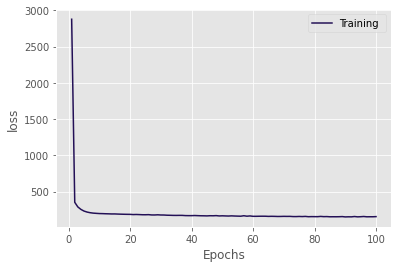

********** Successfully loaded weights from weights_090_150.56535.hdf5 file **********


In [11]:
h = model.fit(x=TrainX, y=TrainY, verbose=0)

In [12]:
model.evaluate(x=TrainX, y=TrainY, metrics=['r2', 'nse', 'rmse'])

assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
27/27 [==============================] - 0s 462us/step


{'r2': 0.8287747129910914,
 'nse': 0.8242104533788417,
 'rmse': 12.395706486756165}

In [13]:
model.evaluate(x=TestX, y=TestY, metrics=['r2', 'nse', 'rmse'])

12/12 [==============================] - 0s 545us/step


{'r2': 0.7797056476775908,
 'nse': 0.6953130002838437,
 'rmse': 19.062730432656256}

In [14]:

spliter = TrainTestSplit()
train_x, val_x, train_y, val_y = spliter.split_by_slicing(TrainX, TrainY)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((588, 11), (252, 11), (588, 1), (252, 1))

In [15]:
PREFIX = f"hpo_nn_{dateandtime_now()}"
ITER = 0
SEP = os.sep
num_iterations = 50

In [16]:

SUGGESTIONS = {}



It is always a good practice to monitor more than 1 performance metric,
even though our objective function will not be based upon these
performance metrics.

In [17]:
MONITOR = {"rmse": [], "nse": [], "r2": [], "pbias": [], "nrmse": []}

### 2) define objective function



In [18]:
def objective_fn(
        prefix: str = None,
        return_model: bool = False,
        fit_on_all_training_data:bool = False,
        epochs:int = 100,
        verbosity: int = 0,
        **suggestions
)->Union[float, Model]:
    """
    This function must build, train and evaluate the ML model.
    The output of this function will be minimized by optimization algorithm.

    In this example we are considering same number of units and same activation for each
    layer. If we want to have (optimize) different number of units for each layer,
    willhave to modify the parameter space accordingly. The LSTM function
    can be used to have separate number of units and activation function for each layer.

    Parameters
    ----------
    prefix : str
        prefix to save the results. This argument will only be used after
        the optimization is complete
    return_model : bool, optional (default=False)
        if True, then objective function will return the built model. This
        argument will only be used after the optimization is complete
    epochs : int, optional
        the number of epochs for which to train the model
    verbosity : int, optional (default=1)
        determines the amount of information to be printed
    fit_on_all_training_data : bool, optional
        Whether to predict on all the training data (training+validation)
        or to training on only training data and evaluate on validation data.
        During hpo iterations, we will train the model on training data
        and evaluate on validation data. After hpo, we the model is
        trained on allt he training data and evaluated on test data.
    suggestions : dict
        a dictionary with values of hyperparameters at the iteration when
        this objective function is called. The objective function will be
        called as many times as the number of iterations in optimization
        algorithm.

    Returns
    -------
    float or Model
    """
    suggestions = jsonize(suggestions)
    global ITER

    # i) build model
    _model = Model(
        model=MLP(units=suggestions['units'],
                   num_layers=suggestions['num_layers'],
                   activation=suggestions['activation'],
                   dropout=0.2),
        batch_size=suggestions["batch_size"],
        lr=suggestions["lr"],
        prefix=prefix or PREFIX,
        epochs=epochs,
        input_features=data.columns.tolist()[0:-1],
        output_features=data.columns.tolist()[-1:],
        verbosity=verbosity)

    SUGGESTIONS[ITER] = suggestions

    # ii) train model
    
    if fit_on_all_training_data:
        _model.fit(x=TrainX, y=TrainY, validation_data=(TestX, TestY), verbose=0)
        prediction = _model.predict(x=TestX)
        true = TestY
    else:
        _model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), verbose=0)
        prediction = _model.predict(x=val_x)
        true = val_y

    # iii) evaluate model
    metrics = RegressionMetrics(true, prediction)
    val_score = metrics.rmse()

    for metric in MONITOR.keys():
        val = getattr(metrics, metric)()
        MONITOR[metric].append(val)

    # here we are evaluating model with respect to mse, therefore
    # we don't need to subtract it from 1.0
    if not math.isfinite(val_score):
        val_score = 9999

    best_score = round(np.nanmin(MONITOR['rmse']), 2)
    best_iter = np.argmin(MONITOR['rmse'])
    print(f"{ITER} {round(val_score, 2)} . Best was {best_score} at {best_iter}")


    ITER += 1

    if return_model:
        return _model

    return val_score

### 3) define parameter space
 parameter space



In [19]:
param_space = [
    Integer(10, 30, name="units"),
    Integer(1, 2, name="num_layers"),
    Categorical(["relu", "elu", "tanh"], name="activation"),
    Real(0.00001, 0.01, name="lr"),
    Categorical([4, 8, 12, 16, 24], name="batch_size")
]

### 4) initial state
 initial values



In [20]:
x0 = [14, 1, "relu", 0.001, 8]

### 5) run optimization algorithm
 initialize the HyperOpt class and call fit method on it



In [21]:
optimizer = HyperOpt(
    algorithm="bayes",
    objective_fn=objective_fn,
    param_space=param_space,
    x0=x0,
    num_iterations=num_iterations,
    process_results=False, # we can turn it False if we want post-processing of results
    opt_path=f"results{SEP}{PREFIX}"
)



assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
0 11.42 . Best was 11.42 at 0
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
1 17.02 . Best was 11.42 at 0
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
2 12.76 . Best was 11.42 at 0
assigning name input_1 to IteratorGetNext:0 with shape (12, 11)
assigning name input_1 to IteratorGetNext:0 with shape

assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
28 10.28 . Best was 10.28 at 28
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
29 10.57 . Best was 10.28 at 28
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
30 11.63 . Best was 10.28 at 28
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
assigning name input_1 to IteratorGetNext:0 wi

In [ ]:
results = optimizer.fit()

In [27]:
best_iteration = optimizer.best_iter()

print(f"optimized parameters are \n{optimizer.best_paras()} at {best_iteration}")

optimized parameters are 
{'units': 24, 'num_layers': 1, 'activation': 'elu', 'lr': 0.0026679385190848475, 'batch_size': 8} at 42


we are interested in the minimum value of following metrics



In [28]:
for key in ['rmse', 'nrmse', 'pbias']:
    print(key, np.nanmin(MONITOR[key]), np.nanargmin(MONITOR[key]))

rmse 10.163124154662176 42
nrmse 0.10163124154662176 42
pbias -24.70877096103889 1


we are interested in the maximum value of following metrics



In [29]:
for key in ['r2', 'nse']:
    print(key, np.nanmax(MONITOR[key]), np.nanargmax(MONITOR[key]))

r2 0.9031089866228091 43
nse 0.8996102188040533 42


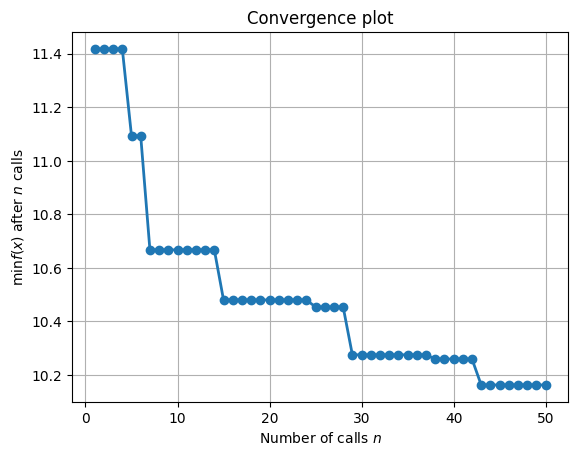

In [30]:
_ = optimizer._plot_convergence()

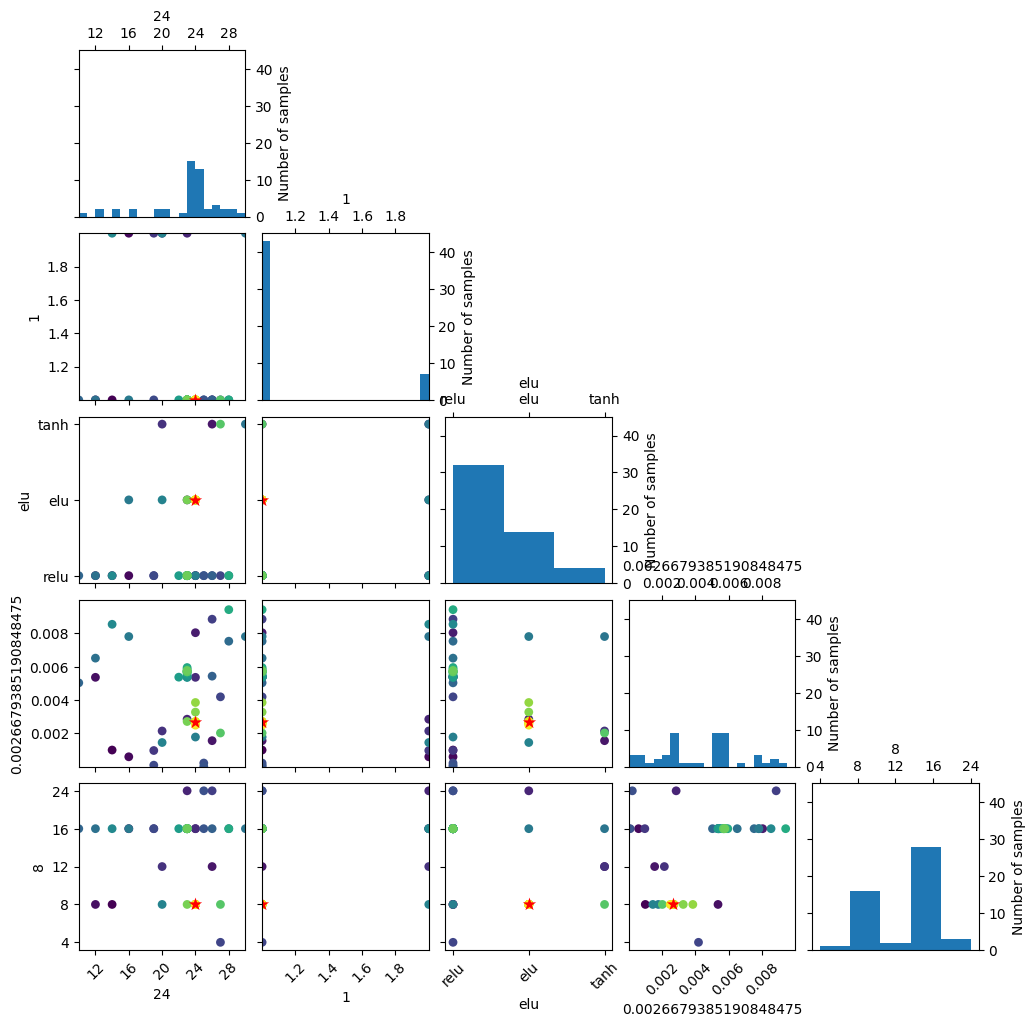

In [31]:
_ = optimizer._plot_evaluations()

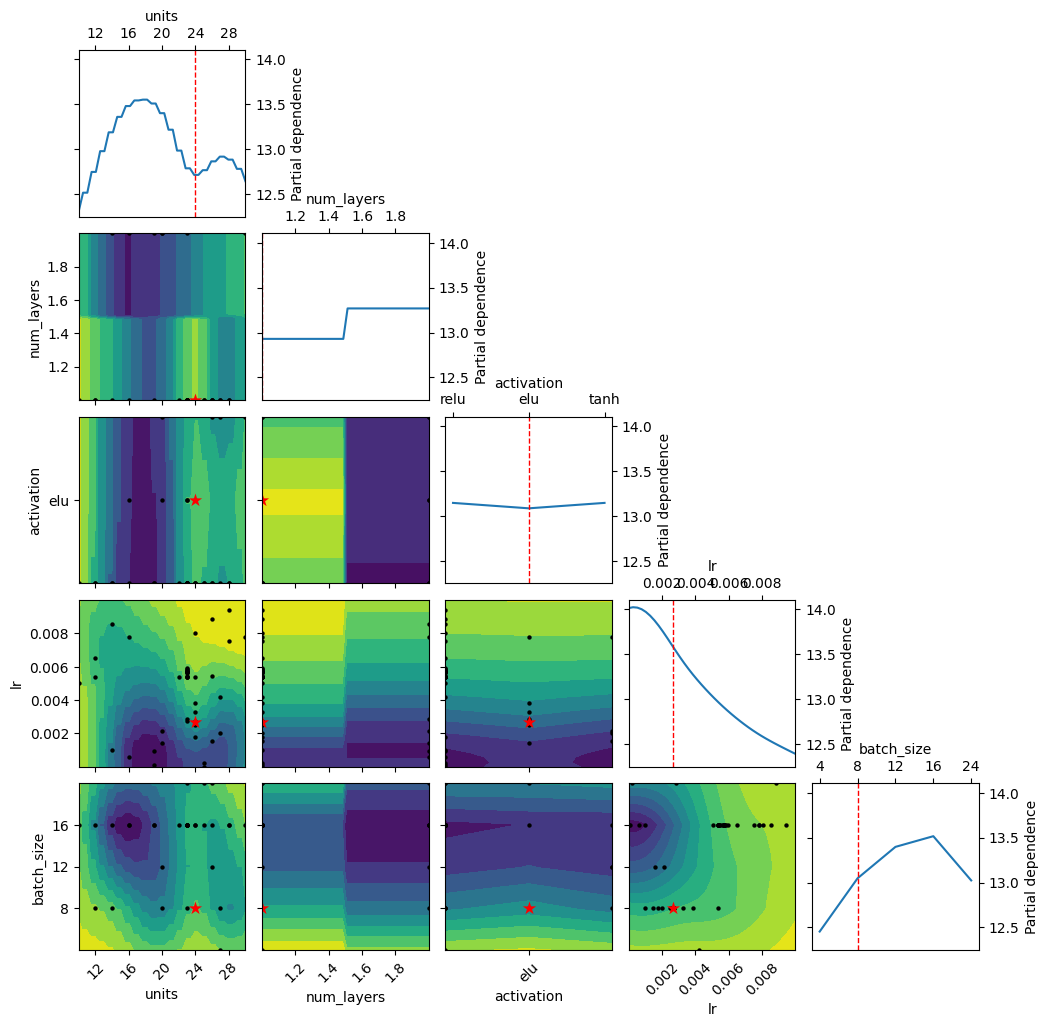

In [34]:
_ = plot_objective(optimizer.gpmin_results)

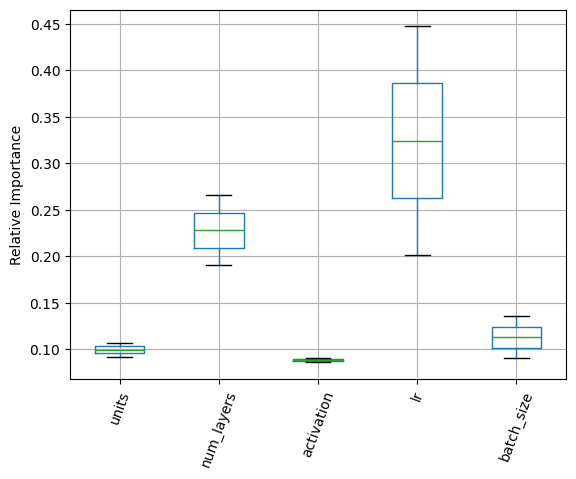

In [42]:
_ = optimizer.plot_importance()

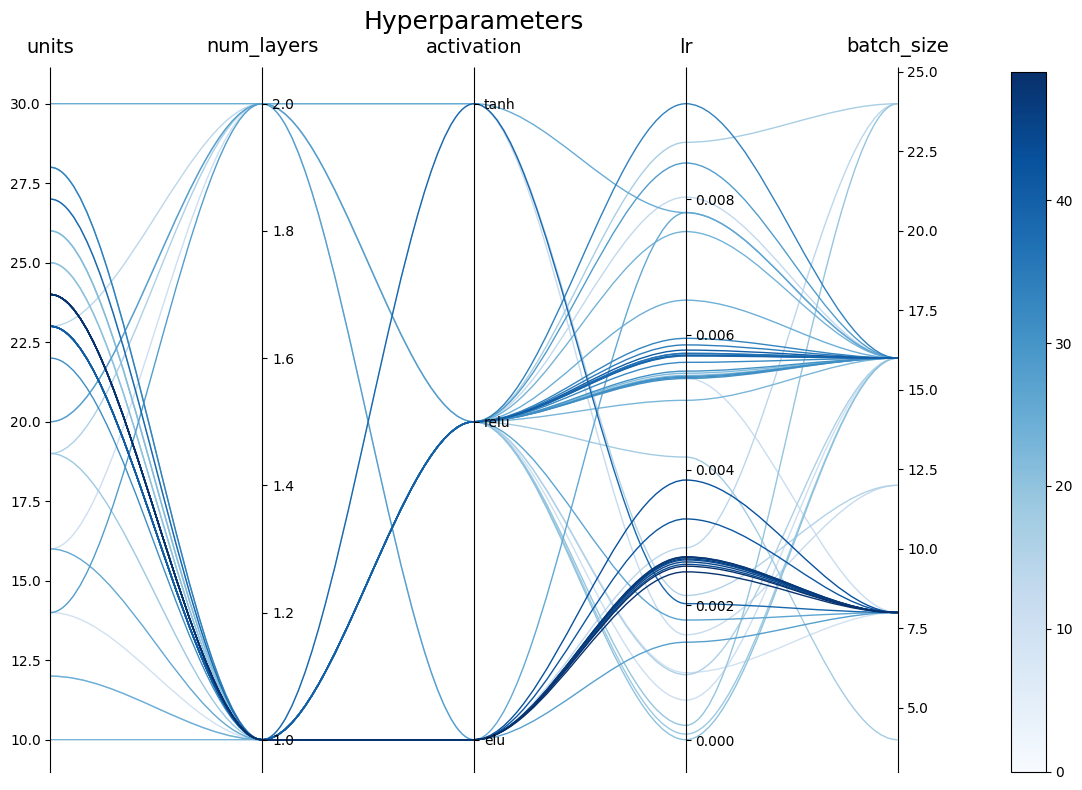

In [36]:
_ = optimizer.plot_parallel_coords(figsize=(12, 8))

we can now again call the objective function with best/optimium parameters

### 6) train with best hyperparameters




            building DL model for  
            regression problem using Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 Dense_0 (Dense)             (None, 24)                288       
                                                                 
 Dropout (Dropout)           (None, 24)                0         
                                                                 
 Flatten (Flatten)           (None, 24)                0         
                                                                 
 Dense_out (Dense)           (None, 1)                 25        
                                                                 
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________

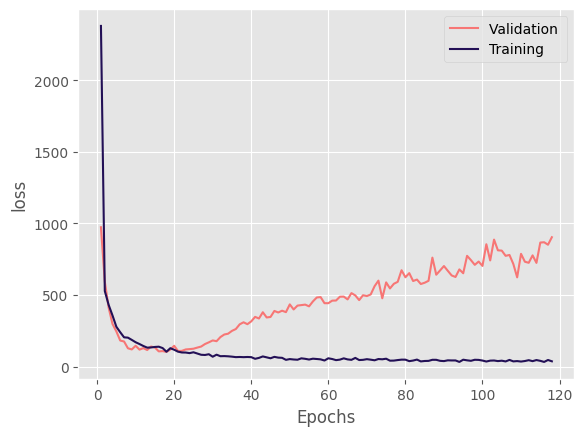

********** Successfully loaded weights from weights_018_103.28909.hdf5 file **********
assigning name input_1 to IteratorGetNext:0 with shape (None, 11)
8/8 [==============================] - 0s 718us/step
51 10.16 . Best was 10.16 at 42


In [37]:
model = objective_fn(prefix=f"{PREFIX}{SEP}best",
                     return_model=True,
                     epochs=500,
                     verbosity=1,
                     **optimizer.best_paras())

In [39]:
model.evaluate(x=TrainX, y=TrainY, metrics=['r2', 'nse', 'rmse'])

27/27 [==============================] - 0s 577us/step


{'r2': 0.9207692548958313,
 'nse': 0.9197818715253115,
 'rmse': 8.373577108689467}

In [40]:
model.evaluate(x=TestX, y=TestY, metrics=['r2', 'nse', 'rmse'])

12/12 [==============================] - 0s 636us/step


{'r2': 0.8285461122661508, 'nse': 0.798126539273869, 'rmse': 15.51664265346751}

In [43]:
optimizer.opt_path

'results\\hpo_nn_20230207_181011'

In [45]:

optimizer.save_results(results)